### Convex Optimization: HW3 ###

Q2. Implement the barrier method to solve QP.


In [ ]:
import numpy as np

def objective(v, Q, p, A, b, t):
    if np.any(b - A @ v <= 0):
        return float("NaN")
    return t * (v.T @ Q @ v + p.T @ v) - np.sum(np.log(b - A @ v))

def grad_objective(v, Q, p, A, b, t):
    phi = 1. / (b - A @ v)
    return t * (2 * Q @ v + p) + A.T @ phi

def hess_objective(v, Q, p, A, b, t):
    phi = 1. / (b - A @ v)
    return 2 * t * Q + A.T @ np.diag(phi)**2 @ A

def f0(v,Q,p):
    return v.T.dot(Q).dot(v) + p.T.dot(v)

def phi(A,v,b):
    total = 0
    for i in range(len(b)):
        #if -A[i].dot(v) + b[i] <= 0:
        #    raise ValueError("Infeasible starting point: the argument of the log must be positive.")
        total += np.log(-A[i].dot(v) + b[i])
    return -total



def backtracking(v, Q, p, A, b, t, alpha=0.49, beta=0.95):
    grad = grad_objective(v, Q, p, A, b, t)
    hess = hess_objective(v, Q, p, A, b, t)
    newton_step = np.linalg.pinv(hess) @ grad
    u = 1.0
    while objective(v + u * newton_step, Q, p, A, b, t) > objective(v, Q, p, A, b, t) + alpha * u * grad.T.dot(newton_step) and u > 1e-6:
        if np.any(-A.dot(v + u * newton_step) + b <= 0):
            return u
        u *= beta
    return u

def centering_step(Q, p, A, b, t, v0, eps, max_iter=1000):
    v = np.copy(v0)
    for k in range(max_iter):
        grad = grad_objective(v, Q, p, A, b, t)
        hess = hess_objective(v, Q, p, A, b, t)
        newton_step = -np.linalg.pinv(hess) @ grad
        lambda_sq = -grad.T.dot(newton_step)

        if lambda_sq / 2 <= eps:
            break

        u = backtracking(v, Q, p, A, b, t)
        v_new = v + u * newton_step
        v = v_new
    return v

def barr_method(Q,p,A,b,v0,eps,mu=2.):
    list_v = [v0]
    m = len(b)
    t = 1.
    v = v0
    while m/t >= eps:
        v = centering_step(Q,p,A,b,t,v,eps)
        t *= mu
        list_v.append(v)
    return list_v



Q3. Test your function on randomly generated matrices X and observations y with $\lambda$ = 10.

<>:48: SyntaxWarning: invalid escape sequence '\m'
<>:48: SyntaxWarning: invalid escape sequence '\m'
C:\Users\vasya\AppData\Local\Temp\ipykernel_18308\1834261707.py:48: SyntaxWarning: invalid escape sequence '\m'
  label=f"$\mu = {mu_values[i]}$",


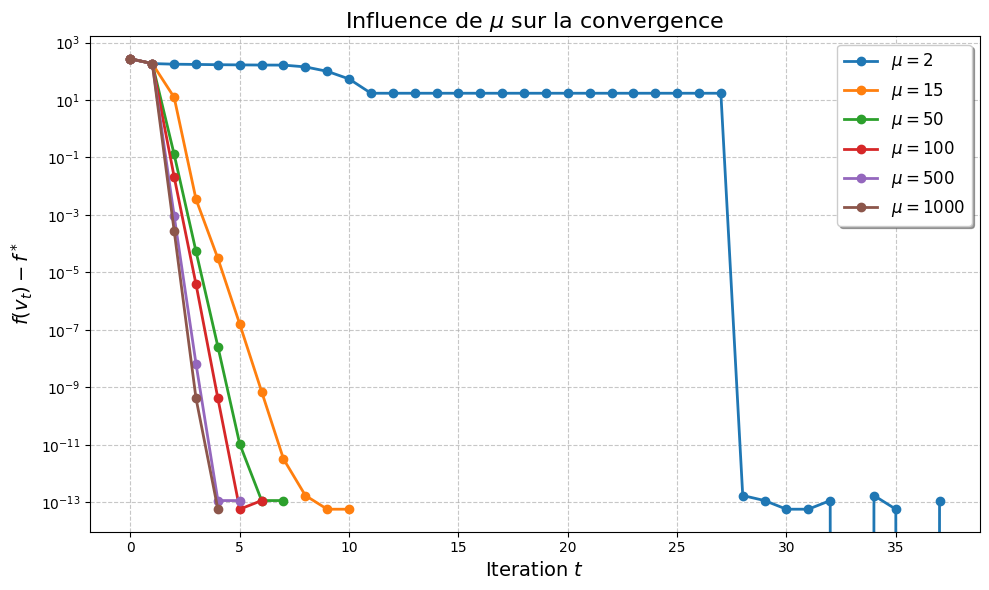

In [ ]:
import matplotlib.pyplot as plt

def generate_parameters(n, d, reg=10):
    
    X = 3 * np.random.randn(n, d)
    y = 5 + 1.5 * np.random.randn(n)

    Q = np.eye(n) / 2
    p = - y

    A = np.concatenate((X.T, - X.T), axis=0)
    b = reg * np.ones(2 * d)

    v0 = np.zeros(n)

    return X, y, Q, p, A, b, v0

def dual(v, Q, p):
    return v.T @ Q @ v + p.T @ v

n, d, reg = 20, 50, 10
X, y, Q, p, A, b, v0 = generate_parameters(n, d, reg)
eps = 1e-9
alpha, beta = .5, .9
max_iter = 500

mu_values = [2, 15, 50, 100, 500, 1000]
results = [barr_method(Q, p, A, b, v0, eps,mu) for mu in mu_values]
f_values = [[dual(v, Q, p) for v in results[i]] for i in range(len(results))]
f_star = np.infty
for i in range(len(results)):
    for v in f_values[i]:
        if f_star > v:
            f_star = v

# Initialisation du graphique
plt.figure(figsize=(10, 6))

# Personnalisation des axes
plt.xlabel('Iteration $t$', fontsize=14)
plt.ylabel('$f(v_t) - f^*$', fontsize=14)
plt.title('Influence of $\\mu$ on convergence', fontsize=16)

# Boucle pour tracer les courbes pour chaque valeur de mu
for i in range(len(results)):
    plt.semilogy(
        f_values[i] - f_star, 
        label=f"$\mu = {mu_values[i]}$", 
        linewidth=2, 
        marker='o', 
        markersize=6
    )

# Personnalisation de la légende
plt.legend(fontsize=12, loc="upper right", frameon=True, shadow=True)

# Ajout d'une grille
plt.grid(which='both', linestyle='--', alpha=0.7)

# Ajustement des marges
plt.tight_layout()

# Afficher le graphique
plt.show()
